In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import yaml
from os.path import exists

from scipy.spatial import distance_matrix
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import torch
from sklearn import metrics
import xgboost as xgb 
import pandas as pd

from data import DataGatherer
import params
# from test import encode_data
from models import load_model

In [2]:
param_dic = params.__get_dict__()
print(param_dic["data_spliting"])

{'additional_samples': 0,
 'arcface': True,
 'arcface_margin': 0.1,
 'arcface_scale': 16,
 'augmentations': ['addSomeNoise'],
 'batch_size': 32,
 'class_hidden_size': 256,
 'class_layers_nb': 1,
 'cnn_padding_size': 1,
 'conv_features1_nb': 80,
 'conv_features2_nb': 30,
 'conv_kernel1_size': 15,
 'conv_kernel2_size': 5,
 'conv_layers_nb': 4,
 'convm_embedding_size': 128,
 'convm_kernel_size': 25,
 'convm_layer_nb': 10,
 'convm_out_size': 32,
 'convm_patch_size': 10,
 'data_limit': -1,
 'data_spliting': 'pos_split',
 'data_test_rate': 0.05,
 'data_type': 'not_complex',
 'data_use_position': False,
 'datafile': '/srv/public/Thibaud/datasets/ultrasec/Messung_9/messung9.raw.3_data.npy',
 'device': 'cuda',
 'dropout_value': 0,
 'expender_hidden_size': 256,
 'expender_layers_nb': 1,
 'expender_out': 256,
 'feature_norm': 'layer',
 'flat_data': True,
 'implied_values': <function implied_values at 0x7fcd2555b5b0>,
 'input_type': 'spectrogram',
 'labelfile': '/srv/public/Thibaud/datasets/ultras

In [3]:
# data = np.load("/srv/public/Thibaud/datasets/ultrasec/Messung_9/messung9.2.3_data.npy")
# label = np.load("/srv/public/Thibaud/datasets/ultrasec/Messung_9/messung9.2.3_labels.npy")

data = np.load("/srv/public/Thibaud/datasets/ultrasec/Messung_9/messung9.raw.3_data.npy")
label = np.load("/srv/public/Thibaud/datasets/ultrasec/Messung_9/messung9.raw.3_labels.npy")


data10 = np.load("/srv/public/Thibaud/datasets/ultrasec/Messung_10/messung10.raw.2_data.npy")
label10 = np.load("/srv/public/Thibaud/datasets/ultrasec/Messung_10/messung10.raw.2_labels.npy")



num_classes = max(label[:, 0]) + 1
num_positions = max(label[:, 1]) + 1
print(num_classes, num_positions)

13 50


In [4]:
def read_global_log_file(metric_file):
    df = pd.read_csv(metric_file, skiprows=1, index_col=False)
    df.columns = ["metric", "value", "epoch"]
    return df

In [5]:
# Chose the run to handle
# kky9ernw the 11devices training ViT
# yi02n1z5 the 13devices training ViT
# 5o5apekr other the 13devices training ViT
# 3mfqm00c other 13devices training ViT 
# 7f0i6d3f  11 devicees CNN
# fr35skag on the 10 last devices ViT
# m01lp790 on the 10 last devices CNN
# jkcliorr CNN on 13 devices
# zgg3mg3c Random split CNN
# mre3njut Random split ViT
# 0e6kq76e ViT on 10 last devices
run = "0e6kq76e"
directory = "../data/runs/" + run

# Load config file and update params accordingly
if not exists(directory + '/config.yaml'):
    config_file = directory + "/config.csv"
    conf_df = pd.read_csv(config_file)
    with open(directory + '/config.yaml', 'w') as file:
        documents = yaml.dump(conf_df.to_dict(orient='records')[0], file, default_flow_style=False)
params.__use_config__(directory + '/config.yaml')

# Load metrics from the run
metrics_file = directory + "/log_metrics.csv"
metric_frame = read_global_log_file(metrics_file)
print(metric_frame["metric"].unique())

# Select a epoch from which to load model from 
choice_metric = "F1 score on test data" #
only_metric_frame = metric_frame[metric_frame["metric"]==choice_metric]
kept_epoch = only_metric_frame.loc[only_metric_frame["value"].idxmax()]["epoch"]
print("Epoch of Maximum:", choice_metric, kept_epoch)
print("Maximum:",choice_metric, only_metric_frame.loc[only_metric_frame["value"].idxmax()]["value"])

model = torch.load("../data/runs/" + run +"/model_" + params.saved_model_suffix + "_" + str(kept_epoch)  + ".pth") #model_some_testing_

['Dev class loss' 'Dev class accuracy' 'Encoder loss' 'learning rate'
 'Positive clustering at error rate 0.1%'
 'Positive clustering at error rate 1%'
 'Positive clustering at error rate 10%' 'Trapz'
 'NN classification on test data' 'max_Trapz' 'NN test2train'
 'NN test2train 10th mean' 'Kmeans cluster score %'
 'Accuracy for dev classification on test data %' 'F1 score on test data'
 'epoch']
Epoch of Maximum: F1 score on test data 3
Maximum: F1 score on test data 0.7542345604567074


In [6]:
from data import MyDataset, MyDataLoader


params.data_test_rate = 0.1
# params.batch_size = 256
# params.spectrogram_window_size = 32

def encode_data(mymodel, this_data, this_labels, do_all_data=False):

    z = list(zip(this_data, this_labels))
    loader = MyDataLoader(MyDataset(z))

    mymodel.eval()
    encs, labs = [], []
    count = 0
    amt2encode = len(loader.dataset) * params.data_test_rate
    for i, (batchX, batchY) in enumerate(loader):
        # Compute encoded version of the data by our embedding model
        encs = encs + mymodel.encode(batchX).tolist()
        # Gather device labels accordingly (eventually randomly enumerated)
        labs = labs + batchY.tolist()
        count += batchX.shape[0]
        if not do_all_data and count > amt2encode:
            break
    return encs, labs

In [7]:
encoded_data, encoded_labels = encode_data(model, data, label)
encoded_data10, encoded_labels10 = encode_data(model, data10, label10)

encoded_data10 = np.array(encoded_data10)
encoded_labels10 = np.array(encoded_labels10)

# Random projection
# encoded_data = np.random.rand(50000, 350)
# random_dev_label = np.expand_dims(np.random.choice(13, size=50000), axis=1)
# random_pos_label = np.expand_dims(np.random.choice(50, size=50000), axis=1)
# encoded_labels = np.concatenate((random_dev_label, random_pos_label), axis=1)

# encoded_data10 = np.random.rand(50000, 350)
# random_dev_label = np.expand_dims(np.random.choice(13, size=50000), axis=1)
# random_pos_label = np.expand_dims(np.random.choice(50, size=50000), axis=1)
# encoded_labels10 = np.concatenate((random_dev_label, random_pos_label), axis=1)

print("Size of the sub_set of encoded points: ", len(encoded_data))


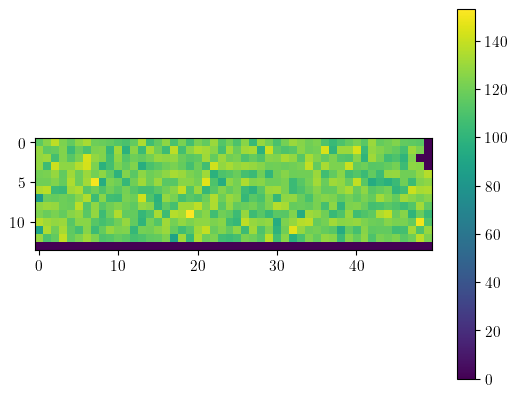

In [ ]:
# SEE WHERE IS WHAT
cleaner_labels = np.array(encoded_labels)

pos_ids = [np.where(cleaner_labels[:,1] == i) for i in range(50)]
dev_ids = [np.where(cleaner_labels[:,0] == i) for i in range(14)]

m = []
for dev in range(14):
    m.append([])
    for pos in range(50):
        ids = list(set(dev_ids[dev][0]) & set(pos_ids[pos][0]))
        m[dev].append(len(ids))

m = np.array(m)
plt.imshow(m)
plt.colorbar()
plt.show()

# To do to try

- XGBoost classify the encoded values
- Code a little Re-Identification setup on the test+train data
    - Basic anchor + distance to anchor seting (no need to update)
- Vote on n sample of same device elements (does it improve from accuracy ?)
- Estimate the time to encode + computational needs
- Try isolated device from train to reid between all positions
- Try multiple unseen positions if they match one to another
- Do a study of capabilities according to the amount of data available and it's cleaness

In [ ]:
# Plotting
def scatter_plot(X, Y, visible_legend=True):
        dimentions = [[2*i, i*2+1] for i in range(1)]
        colors_base = cm.rainbow(np.linspace(0, 1, num_classes))
        # plt.rcParams["figure.figsize"] = (5,5)
        cmap, norm = matplotlib.colors.from_levels_and_colors(np.arange(0, num_classes+1)- 0.5, colors_base)

        print(X.shape)
        print(Y.shape)

        for i in range(len(dimentions)):
                fig, ax = plt.subplots()
                scatter = ax.scatter(X[:, dimentions[i][0]], X[:, dimentions[i][1]], c=Y, norm=norm, cmap=cmap, marker=".", linewidths=0.5, s=25)
                if visible_legend :
                        handles, lab = scatter.legend_elements(prop="colors", num=num_classes, alpha=0.6)
                        legend1 = ax.legend(handles, lab,
                                loc="lower left", title="Device id")
                        ax.add_artist(legend1)
                        ax.set_title("dimentions " + str(i*2) + "and " + str(i*2+1))
                # .legend(loc='upper left',prop = {'size':7},bbox_to_anchor=(1,1))
                # plt.tight_layout(pad=5)
                if not visible_legend:
                        ax.legend().set_visible(False)
                plot_img = "data/plot_"+str(i)+".png"
        return fig

(77152, 128) (77152, 2)
(7715, 128)
(7715,)


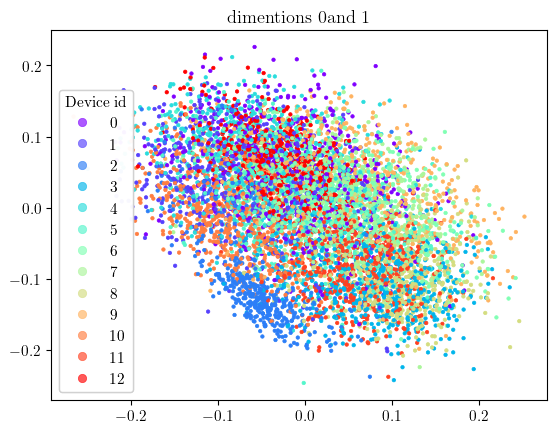

In [ ]:
encoded_data = np.array(encoded_data)
encoded_labels = np.array(encoded_labels)

print(encoded_data.shape, encoded_labels.shape)

r = np.random.choice(len(encoded_data), size=len(encoded_data)//10, replace=False)
scatter_plot(np.array(encoded_data)[r], np.array(encoded_labels)[r][:, 0])
plt.show()

In [ ]:
def compute_anchors(this_data, this_labels):
    centroids = []
    for dev in set(this_labels):
        ids_dev = np.where(np.array(this_labels) == dev)[0]
        class_encoded = np.array(this_data)[ids_dev]
        # Should this be a euclidien mean value ??
        centroids.append(class_encoded.mean(axis=0))

    centroids = np.array(centroids)
    print(centroids.shape)

    return centroids

def get_reid_prediction(anchors, this_data, anchor_labels):
    set_labels = list(set(anchor_labels))
    distances_centers = distance_matrix(this_data, anchors)
    predicted_id = np.argmin(distances_centers, axis=1)
    predicted_class = list(map(lambda x: set_labels[x], predicted_id))
    return predicted_class

# The evaluations

In [ ]:
def re_id_report(anchors_ids, query_ids, query10=False, tight_print=True):

    print("***************")
    print("RE-ID PROTOCOLE")
    print("***************")

    # Compile the re-identification process accuracy
    if query10:
        query_ids = np.random.choice(len(encoded_labels10), len(encoded_labels10)//100, replace=False)
        print(" Perform query with elements from dataset 10: size=", len(query_ids))
        query_labels = encoded_labels10[query_ids][:, 0]
        query_data = encoded_data10[query_ids]
    else :
        query_labels = encoded_labels[query_ids][:, 0]
        query_data = encoded_data[query_ids]

    anchor_labels = encoded_labels[anchors_ids][:, 0]
    anchors = compute_anchors(encoded_data[anchors_ids], anchor_labels)
    print("Number of anchors: ", len(anchors))
    query_predictions = get_reid_prediction(anchors, query_data, anchor_labels)


    if tight_print :
        print("Weighted F1 score for Re-id: ", metrics.f1_score(query_labels, query_predictions, average='weighted'))
    else :
        print('confusion matrix')
        conf_mx =confusion_matrix(query_labels, query_predictions)
        # print(conf_mx)

        # Confusion Matrix Display
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx,
                                    display_labels=set(query_labels))
        disp.plot()
        # plt.show()

        print('classification_report')
        print(classification_report(query_labels, query_predictions))

In [ ]:
def clustering_evaluation(anchors_ids, query_ids, query10=False, tight_print=True, all_data=False):
    if query10:
        query_ids = np.random.choice(len(encoded_labels10), len(encoded_labels10)//50, replace=False)
        print(" Perform query with elements from dataset 10: size=", len(query_ids))
        query_labels = encoded_labels10[query_ids][:, 0]
        query_data = encoded_data10[query_ids]
    else:
        used_ratio = 0.1
        if all_data:
            subset = np.array(list(range(len(encoded_labels[query_ids]))))
        else :
            subset = np.random.choice(len(encoded_labels[query_ids]), int(len(encoded_labels[query_ids])*used_ratio), replace=False)
        print("Metric calculated on ", str(len(subset)), "samples")
        query_labels = encoded_labels[query_ids][:, 0][subset]
        query_data = encoded_data[query_ids][subset]

    mat = distance_matrix(query_data, query_data)
    num_test_dev = max(query_labels)
    
    same_distances = []
    diff_distances = []

    dev_ind = [np.where(np.array(query_labels)==i)[0] for i in range(num_test_dev)]
    for i in range(num_test_dev):
        for j in range(i, num_test_dev):
            sub_mat = mat[dev_ind[i]].T
            subsub_mat = sub_mat[dev_ind[j]]
            for ind_i in range(len(subsub_mat)):
                for ind_j in range(ind_i+1, len(subsub_mat[0])):
                    d = subsub_mat[ind_i][ind_j]
                    if i==j :
                        same_distances.append(d)
                    else :
                        diff_distances.append(d)

    roc_value = []
    th_steps = 50
    min_dist = min(same_distances)
    if len(diff_distances)==0:
        max_dist = min_dist*2
    else :
        max_dist = max(diff_distances)

    for th in range(th_steps+1):
        t = ((th+0.5)/th_steps)
        t = t*t
        threshold = t*max_dist + (1 - t)*min_dist
#         threshold = threshold * threshold
        ta = len(np.where(np.array(same_distances) < threshold)[0])/len(same_distances)
        fa = len(np.where(np.array(diff_distances) < threshold)[0])/len(diff_distances)
        roc_value.append([fa, ta, threshold])
    roc_value = np.array(roc_value) 
    area = np.trapz(roc_value[:, 1], roc_value[:, 0])

    # Get accuracy when fa=0.1% , 1%, 10%
    targets_fa = [0.001, 0.01, 0.1]
    current_target_fa_id = 0
    target_th = []
    ta_accuracy =[]
    for i in range(len(roc_value)):
        if roc_value[i][0] >= targets_fa[current_target_fa_id]:
            target_th.append(roc_value[i][2])
            ta_accuracy.append(roc_value[i][1])
            current_target_fa_id += 1
            if current_target_fa_id >= len(targets_fa):
                break
        
    if tight_print:
        print("> Area size under the clustering curve (Trapz):", area)
    else:
        print("Percentage of each label by value", 100*np.histogram(query_labels, bins=len(set(query_labels)))[0]/len(query_labels))

        print("MaxMin of same:", max(same_distances), min(same_distances))
        print("MaxMin of diff:", max(diff_distances), min(diff_distances))

        print("> Amount of positive clustering when False accuracy reaches 0,1% 1% and 10%")
        print(list(100*np.array(ta_accuracy)), "%")

        print("> Area size under the clustering curve (Trapz)")
        print(area)

In [ ]:
def clustering_other_metrics_evaluation(anchors_ids, query_ids, query10=False):
    query_labels = encoded_labels[query_ids][:, 0]
    anchor_labels = encoded_labels[anchors_ids][:, 0]
    querys = encoded_data[query_ids]
    anchors = encoded_data[anchors_ids]

    sil_score = metrics.silhouette_score(querys, query_labels)
    ch_score = metrics.calinski_harabasz_score(querys, query_labels)
    db_score = metrics.davies_bouldin_score(querys, query_labels)

    print("***********************")
    print("SOME CLUSTERING METRICS")
    print("***********************")


    print("Query clustering scores: ", )
    print("Silhouette score in [-1, 1] - ", sil_score)
    print("Calinski Harabasz score [relative] - ", ch_score)
    print("Davies Bouldin score [lower the better] - ", db_score)

In [ ]:
def xgboost_evaluation(anchors_ids, query_ids, tight_print=True, query10=False):
    if query10:
        query_ids = np.random.choice(len(encoded_labels10), len(encoded_labels10)//50, replace=False)
        print(" Perform query with elements from dataset 10: size=", len(query_ids))
        query_labels = encoded_labels10[query_ids][:, 0]
        querys = encoded_data10[query_ids]
    else :
        query_labels = encoded_labels[query_ids][:, 0]
        querys = encoded_data[query_ids]

    anchor_labels = encoded_labels[anchors_ids][:, 0]
    anchors = encoded_data[anchors_ids]


    # Model training
    if False:
        xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)

        xgb_model.fit(anchors, anchor_labels)

        predicted_class = xgb_model.predict(querys)
    else :
        from sklearn.linear_model import SGDClassifier
        from sklearn.preprocessing import StandardScaler
        from sklearn.pipeline import make_pipeline
        clf = make_pipeline(StandardScaler(),
                            SGDClassifier(max_iter=1000, tol=1e-3))
        clf.fit(anchors, anchor_labels)
        predicted_class = clf.predict(querys)



    print("*****************************")
    print("XGB CLASSIFICATION EVALUATION")
    print("*****************************")

    if tight_print :
        print("Weighted F1 score for linear separation: ", metrics.f1_score(query_labels, predicted_class, average='weighted'))
    else:
        print('confusion matrix')
        conf_mx =confusion_matrix(query_labels, predicted_class)
        # print(conf_mx)

        # Confusion Matrix Display
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx,
                                    display_labels=set(query_labels))
        disp.plot()
        plt.show()

        print('classification_report')
        print(classification_report(query_labels, predicted_class))

# Preparing eval data

In [202]:
test_dev = [0, 1, 2] #list(range(13)) #[11, 12]
test_pos = [5, 10, 15]

validation_dev = list(range(13))
validation_pos = [5, 10, 15]

training_dev = [i for i in range(13) if not i in test_dev]
training_pos = [i for i in range(48) if not i in validation_pos]

print(training_pos)

dev_ids = [np.where(encoded_labels[:,0] == i) for i in range(14)]
pos_ids = [np.where(encoded_labels[:,1] == i) for i in range(50)]

[0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


In [203]:
# Separate the indexes from data and label according to the scenarios
train_ids = []
val_ids = []
test_ids = []
scenario2_anchors_ids = []
scenario2_query_ids = []
scenario3_anchors_ids = []
scenario3_query_ids = []
scenario4_anchors_ids = []
for dev in range(len(dev_ids)):
    for pos in range(len(pos_ids)): 
        inter_ids = list(set(dev_ids[dev][0]) & set(pos_ids[pos][0]))   
        scenario4_anchors_ids = scenario4_anchors_ids + inter_ids
        # Base separation according to "dev" and "pos" value
        if dev in training_dev and pos in training_pos :
            train_ids = train_ids + inter_ids
            # # Also add distractors to scenario 3
            # scenario3_anchors_ids = scenario3_anchors_ids + inter_ids
        elif dev in validation_dev and pos in validation_pos :
            val_ids = val_ids + inter_ids
            # # Also add distractors to scenario 3
            # scenario3_anchors_ids = scenario3_anchors_ids + inter_ids
        if pos in test_pos :
            test_ids = test_ids + inter_ids
            # Scenario 3 specific
            if pos == test_pos[0] :#and dev in test_dev:  # Select 1 unseen position as the anchor source
                # print("Anchors:", dev, pos)
                scenario3_anchors_ids = scenario3_anchors_ids + inter_ids
            elif dev in test_dev :                  # Other positions are for queries
                # print("Queries:", dev, pos)
                scenario3_query_ids = scenario3_query_ids + inter_ids

        else :
            assert("what is this unclassified data:{:1f}, {:1f}".format(dev, pos))

        # Transversal separation
        if dev in validation_dev and pos in validation_pos :  # Seen devices and 2 unseen positions
            if pos == validation_pos[0]:
                scenario2_anchors_ids = scenario2_anchors_ids + inter_ids
            else :
                scenario2_query_ids = scenario2_query_ids + inter_ids


In [204]:
print(len(train_ids))
print(len(val_ids))
print(len(test_ids))
print(len(scenario2_anchors_ids))
print(len(scenario2_query_ids))
print(len(scenario3_anchors_ids))
print(len(scenario3_query_ids))
print(len(scenario4_anchors_ids))

69832
4701
0
1623
3078
0
0
77152


# Scenario 2 With incorporated classifier

In [205]:
params.data_test_rate = 0.2

def encode_prediction_data(mymodel, this_data, this_labels, do_all_data=False):

    z = list(zip(this_data, this_labels))
    loader = MyDataLoader(MyDataset(z))

    mymodel.eval()
    encs, labs = [], []
    count = 0
    amt2encode = len(loader.dataset) * params.data_test_rate
    for i, (batchX, batchY) in enumerate(loader):
        # Compute encoded version of the data by our embedding model
        encs = encs + mymodel(batchX).tolist()
        # Gather device labels accordingly (eventually randomly enumerated)
        labs = labs + batchY.tolist()
        count += batchX.shape[0]
        if not do_all_data and count > amt2encode:
            break
    return encs, labs

In [206]:
preditected_data, true_labels = encode_prediction_data(model, data, label)

In [207]:
preditected_data = np.array(preditected_data)
true_labels = np.array(true_labels)
scenario2direct_query_id = []


dev_ids = [np.where(true_labels[:,0] == i) for i in range(14)]
pos_ids = [np.where(true_labels[:,1] == i) for i in range(50)]
validation_dev = list(range(13))
validation_pos = [5, 10, 15]
for dev in range(len(dev_ids)):
    for pos in range(len(pos_ids)): 
        inter_ids = list(set(dev_ids[dev][0]) & set(pos_ids[pos][0]))
        if pos in validation_pos:
            scenario2direct_query_id = scenario2direct_query_id + inter_ids

(154272, 13)
Amount of data on which we perform this evaluation: 9305
Weighted F1 score for linear separation:  0.6153570019877204
confusion matrix


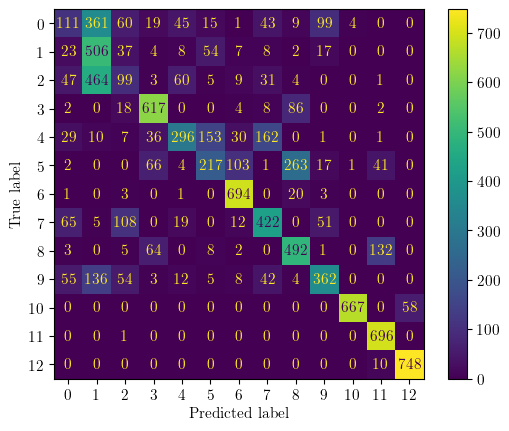

classification_report
              precision    recall  f1-score   support

           0       0.33      0.14      0.20       767
           1       0.34      0.76      0.47       666
           2       0.25      0.14      0.18       723
           3       0.76      0.84      0.80       737
           4       0.67      0.41      0.51       725
           5       0.47      0.30      0.37       715
           6       0.80      0.96      0.87       722
           7       0.59      0.62      0.60       682
           8       0.56      0.70      0.62       707
           9       0.66      0.53      0.59       681
          10       0.99      0.92      0.95       725
          11       0.79      1.00      0.88       697
          12       0.93      0.99      0.96       758

    accuracy                           0.64      9305
   macro avg       0.63      0.64      0.62      9305
weighted avg       0.63      0.64      0.62      9305



In [208]:
import matplotlib as mpl
predicted_class = np.argmax(preditected_data, axis=-1)
print(preditected_data.shape)
print("Amount of data on which we perform this evaluation:", len(scenario2direct_query_id))

print("Weighted F1 score for linear separation: ", metrics.f1_score(true_labels[:, 0][scenario2direct_query_id], predicted_class[scenario2direct_query_id], average='weighted'))
print('confusion matrix')
conf_mx =confusion_matrix(true_labels[:, 0][scenario2direct_query_id], predicted_class[scenario2direct_query_id])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx,
                            display_labels=set(true_labels[:, 0][scenario2direct_query_id]))

# Enable LaTeX formatting
mpl.rcParams['text.usetex'] = True
# Set the global font to be Times New Roman, size 11
mpl.rc('font', family='Times New Roman', size=11)

disp.plot()
plt.savefig("conf_matrix", dpi=300)
plt.show()
print('classification_report')
print(classification_report(true_labels[:, 0][scenario2direct_query_id], predicted_class[scenario2direct_query_id]))


In [179]:
def voting_tail_clf_evaluation(true_labels, predicted_class, nb_samples=1, tight_print=True, same_pos=True):
    
    preditected_data
    
    pos_ids = [np.where(true_labels[:, 1]==i)[0] for i in validation_pos]
    dev_ids = [np.where(true_labels[:, 0]==i)[0] for i in validation_dev]
    all_pos_ids = []
    for pos_i in pos_ids:
        all_pos_ids += list(pos_i)

    real_labels = []
    predicted_class = []
    for d, dev_i in enumerate(dev_ids):
        for p, pos_i in enumerate(pos_ids):
            if len(dev_i)>0 and len(pos_i)>0:
                if same_pos :
                    inter_ids = list(set(dev_i) & set(pos_i))
                else :
                    inter_ids = list(set(dev_i) & set(all_pos_ids))

                # The proba for current ids
                predicted_proba = preditected_data[inter_ids]
                np.random.shuffle(predicted_proba)
                for i in range(len(predicted_proba)//nb_samples):
                    total_proba = np.sum(predicted_proba[i*nb_samples:(i+1)*nb_samples], axis=-2)
                    real_labels.append(d)
                    predicted_class.append(total_proba.argmax())

    print("Multi-sampled vote for:", nb_samples, " samples and same_pos=", same_pos )
    print("Weighted F1 score for linear separation: ", metrics.f1_score(real_labels, predicted_class, average='weighted'))
    if not tight_print:
        print('confusion matrix')
        conf_mx =confusion_matrix(query_labels, predicted_class)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx,
                                    display_labels=set(query_labels))
        disp.plot()
        plt.show()
        print('classification_report')
        print(classification_report(query_labels, predicted_class))

In [181]:
voting_tail_clf_evaluation(true_labels, predicted_class, nb_samples=1, tight_print=True, same_pos=True)
voting_tail_clf_evaluation(true_labels, predicted_class, nb_samples=3, tight_print=True, same_pos=True)
voting_tail_clf_evaluation(true_labels, predicted_class, nb_samples=10, tight_print=True, same_pos=True)
print()
voting_tail_clf_evaluation(true_labels, predicted_class, nb_samples=1, tight_print=True, same_pos=False)
voting_tail_clf_evaluation(true_labels, predicted_class, nb_samples=3, tight_print=True, same_pos=False)
voting_tail_clf_evaluation(true_labels, predicted_class, nb_samples=10, tight_print=True, same_pos=False)


Multi-sampled vote for: 1  samples and same_pos= True
Weighted F1 score for linear separation:  0.6469995868948935
Multi-sampled vote for: 3  samples and same_pos= True
Weighted F1 score for linear separation:  0.7027230332143419
Multi-sampled vote for: 10  samples and same_pos= True
Weighted F1 score for linear separation:  0.7170032643732431

Multi-sampled vote for: 1  samples and same_pos= False
Weighted F1 score for linear separation:  0.6469995868948935
Multi-sampled vote for: 3  samples and same_pos= False
Weighted F1 score for linear separation:  0.7167029070805344
Multi-sampled vote for: 10  samples and same_pos= False
Weighted F1 score for linear separation:  0.7327732315334536


# Scenario 2 aggregated

In [177]:
def voting_xgboost_evaluation(clf, query_ids, nb_samples=1, tight_print=True, same_pos=True):
    query_labels = encoded_labels[query_ids]
    querys = encoded_data[query_ids]

    pos_ids = [np.where(query_labels[:, 1]==i)[0] for i in range(48)]
    dev_ids = [np.where(query_labels[:, 0]==i)[0] for i in range(13)]
    all_pos_ids = []
    for pos_i in pos_ids:
        all_pos_ids += list(pos_i)

    real_labels = []
    predicted_class = []
    for d, dev_i in enumerate(dev_ids):
        for p, pos_i in enumerate(pos_ids):
            if len(dev_i)>0 and len(pos_i)>0:
                if same_pos :
                    inter_ids = list(set(dev_i) & set(pos_i))
                else :
                        inter_ids = list(set(dev_i) & set(all_pos_ids))

                predicted_proba = clf.predict_proba(querys[inter_ids])
                predicted_proba = np.array(predicted_proba)
                np.random.shuffle(predicted_proba)
                for i in range(len(predicted_proba)//nb_samples):
                    total_proba = np.sum(predicted_proba[i*nb_samples:(i+1)*nb_samples], axis=-2)
                    real_labels.append(d)
                    predicted_class.append(total_proba.argmax())

    print("Multi-sampled vote for:", nb_samples, " samples and same_pos=", same_pos )
    print("Weighted F1 score for linear separation: ", metrics.f1_score(real_labels, predicted_class, average='weighted'))
    if not tight_print:
        print('confusion matrix')
        conf_mx =confusion_matrix(query_labels, predicted_class)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx,
                                    display_labels=set(query_labels))
        disp.plot()
        plt.show()
        print('classification_report')
        print(classification_report(query_labels, predicted_class))

In [178]:
anchors_ids = scenario2_anchors_ids
query_ids = scenario2_query_ids

anchor_labels = encoded_labels[anchors_ids][:, 0]
anchors = encoded_data[anchors_ids]

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
# clf = make_pipeline(StandardScaler(),
#                     SGDClassifier(max_iter=1000, tol=1e-3))

base_model = SGDClassifier(max_iter=1000, tol=1e-3)
clf = CalibratedClassifierCV(base_model)

clf.fit(anchors, anchor_labels)

voting_xgboost_evaluation(clf, query_ids, nb_samples=1)
voting_xgboost_evaluation(clf, query_ids, nb_samples=3)
voting_xgboost_evaluation(clf, query_ids, nb_samples=10)
# voting_xgboost_evaluation(clf, query_ids, nb_samples=20)
print()
voting_xgboost_evaluation(clf, query_ids, nb_samples=1, same_pos=False)
voting_xgboost_evaluation(clf, query_ids, nb_samples=3, same_pos=False)
voting_xgboost_evaluation(clf, query_ids, nb_samples=10, same_pos=False)
# voting_xgboost_evaluation(clf, query_ids, nb_samples=20, same_pos=False)

Multi-sampled vote for: 1  samples and same_pos= True
Weighted F1 score for linear separation:  0.5399633697875371
Multi-sampled vote for: 3  samples and same_pos= True
Weighted F1 score for linear separation:  0.5773622875446981
Multi-sampled vote for: 10  samples and same_pos= True
Weighted F1 score for linear separation:  0.5972188138486798

Multi-sampled vote for: 1  samples and same_pos= False
Weighted F1 score for linear separation:  0.5399633697875371
Multi-sampled vote for: 3  samples and same_pos= False
Weighted F1 score for linear separation:  0.5996351448560238
Multi-sampled vote for: 10  samples and same_pos= False
Weighted F1 score for linear separation:  0.6389434475316395


## Scenario 1
Devices and Position from the training set. 

(!) In practice the reported values have been compiled during training on specific datapoints that were excluded from training

In [148]:
np.random.shuffle(train_ids)
anchors_ids = train_ids[:len(train_ids)//2]
query_ids = train_ids[len(train_ids)//2:]

print(len(anchors_ids))
print(len(query_ids))

re_id_report(anchors_ids, query_ids)
clustering_evaluation(anchors_ids, query_ids)
xgboost_evaluation(anchors_ids, query_ids)

34937
34938
***************
RE-ID PROTOCOLE
***************
(13, 128)
Number of anchors:  13
Weighted F1 score for Re-id:  0.793534264332234
Metric calculated on  3493 samples
> Area size under the clustering curve (Trapz): 0.8952149662362635
*****************************
XGB CLASSIFICATION EVALUATION
*****************************
Weighted F1 score for linear separation:  0.7976490329940316


## Scenario 2
All train devices in unknown position

11 Devices in 2 positions

In [93]:
anchors_ids = scenario2_anchors_ids
query_ids = scenario2_query_ids

re_id_report(anchors_ids, query_ids, tight_print=True)
clustering_evaluation(anchors_ids, query_ids)
xgboost_evaluation(anchors_ids, query_ids)

***************
RE-ID PROTOCOLE
***************
(13, 192)
Number of anchors:  13
Weighted F1 score for Re-id:  0.5624517270389502
Metric calculated on  320 samples
> Area size under the clustering curve (Trapz): 0.9173810445482115
*****************************
XGB CLASSIFICATION EVALUATION
*****************************
Weighted F1 score for linear separation:  0.532617314845184


## Scenario 3
Devices and position unknown

In [132]:
anchors_ids = scenario3_anchors_ids
query_ids = scenario3_query_ids

# import tikzplotlib
# import matplotlib as mpl
# mpl.rcParams['text.usetex'] = True
# mpl.rc('font', family='Times New Roman', size=11)
# cols = "tab10"


# plt.gca().set_facecolor('none')
# plt.grid(True, color='lightgray', linestyle='--', linewidth=0.5)
# plt.gca().spines['bottom'].set_color('black')
# plt.gca().spines['left'].set_color('black')
# plt.gca().spines['top'].set_color('black')
# plt.gca().spines['right'].set_color('black')
# plt.gca().xaxis.label.set_color('black')
# plt.gca().tick_params(axis='x', colors='black')
# plt.gca().set_ylabel('TPR for a FPR of 0.1%')
# plt.gca().set_xlabel('Model')
# # sns.set_style("whitegrid")
# # sns.set_context("paper")
# params = [
#     "tick align=outside",
#     "xtick pos=lower",
#     "ytick pos=left",
#     "xmajorticks=true",
#     "ymajorticks=true",
# ]


print("Number of query_ids:", len(query_ids))
re_id_report(anchors_ids, query_ids, tight_print=True)


# tikzplotlib_fix_ncols(plt.gcf())
# tikzplotlib.save('plot.tex', extra_axis_parameters =params)
# plt.savefig("confusion_matrix.png")
# plt.show()

clustering_evaluation(anchors_ids, query_ids, all_data=True)
xgboost_evaluation(anchors_ids, query_ids)


Number of query_ids: 693
***************
RE-ID PROTOCOLE
***************
(13, 128)
Number of anchors:  13
Weighted F1 score for Re-id:  0.16893432010250825
Metric calculated on  693 samples
> Area size under the clustering curve (Trapz): 0.6383658262639325
*****************************
XGB CLASSIFICATION EVALUATION
*****************************
Weighted F1 score for linear separation:  0.1413648080314747


# Scenario 4

Evaluation on complietely different environement.

In [22]:
anchors_ids = train_ids
# query_ids = 

re_id_report(anchors_ids, query_ids, query10=True)
clustering_evaluation(anchors_ids, query_ids, query10=True)
xgboost_evaluation(anchors_ids, query_ids, query10=True)

***************
RE-ID PROTOCOLE
***************
 Perform query with elements from dataset 10: size= 777
(13, 192)
Number of anchors:  13
Weighted F1 score for Re-id:  0.1369772839469732
 Perform query with elements from dataset 10: size= 1555
> Area size under the clustering curve (Trapz): 0.645877023407909
 Perform query with elements from dataset 10: size= 1555
*****************************
XGB CLASSIFICATION EVALUATION
*****************************
Weighted F1 score for linear separation:  0.14087470553301182


# Other random visualisation ect

In [21]:
# For each class, gather the centroid from train data as an anchor
centroids = []

for dev in range(num_classes):
    ids_dev = np.where(np.array(encoded_labels) == dev)[0]
    class_encoded = np.array(encoded_data)[ids_dev]    
    centroids.append(class_encoded.mean(axis=0))

centroids = np.array(centroids)
print(centroids.shape)


NameError: name 'encoded_labels' is not defined

In [22]:
print(encoded_data.shape)
distances_centers = distance_matrix(encoded_data, centroids)
print(distances_centers.shape)
avg_ditance2center = np.mean(distances_centers, axis=0)
print(avg_ditance2center)
plt.plot(avg_ditance2center)
plt.show()

NameError: name 'encoded_data' is not defined

In [23]:
predicted_class = np.argmin(distances_centers, axis=1)
print(max(predicted_class))
print(max(encoded_labels[:, 0]))
print(predicted_class.shape)

NameError: name 'distances_centers' is not defined

In [24]:
print('confusion matrix')
conf_mx =confusion_matrix(encoded_labels[:, 0], predicted_class)
print(conf_mx)

# Confusion Matrix Display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx,
                              display_labels=range(num_classes))
disp.plot()
plt.show()


print('classification_report')
print(classification_report(encoded_labels[:, 0], predicted_class))


print("predicted clusters")
scatter_plot(np.array(encoded_data), np.array(predicted_class))
plt.show()

print("Ground truth labels")
scatter_plot(np.array(encoded_data), np.array(encoded_labels[:, 0]))
plt.show()

confusion matrix


NameError: name 'encoded_labels' is not defined

13 50
(10000, 2)
(10000,)


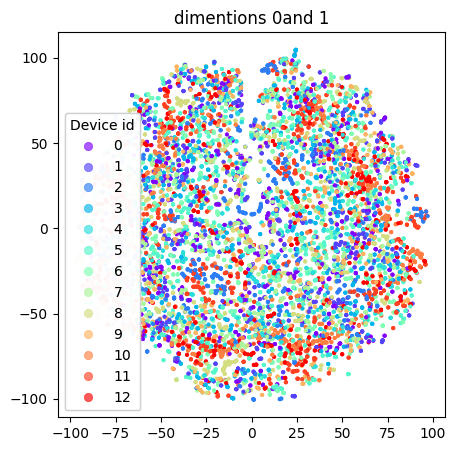

In [25]:
# T-SNE from the raw data
data = np.load("/srv/public/Thibaud/datasets/ultrasec/Messung_9/messung9.raw.3_data.npy")
label = np.load("/srv/public/Thibaud/datasets/ultrasec/Messung_9/messung9.raw.3_labels.npy")

num_classes = max(label[:, 0]) + 1
num_positions = max(label[:, 1]) + 1
print(num_classes, num_positions)


subset = np.random.choice(len(data), 10000)
magnitude_data = list(map(lambda x: np.abs(x), np.array(data)[subset]))
T_SNE_raw = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=10).fit_transform(np.array(magnitude_data))
scatter_plot(T_SNE_raw, label[subset, 0])
plt.show()


In [26]:
# Check miss classification in 2D
sub_encoded_data, sub_encoded_labels = encode_data(model, data[subset], label[subset])
T_SNE_sub_encoded = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=10).fit_transform(np.array(sub_encoded_data))

In [57]:
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(9984, 2)
(9984,)


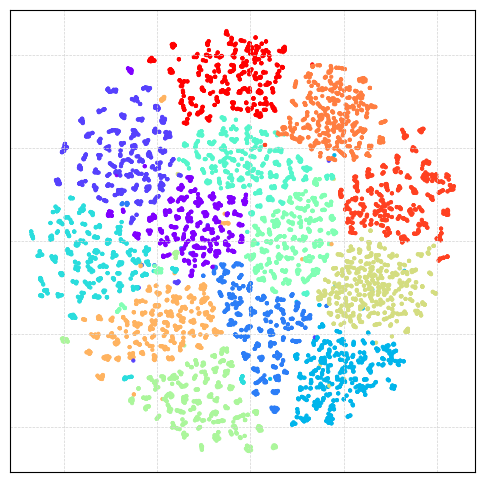

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10000, 2)
(10000,)


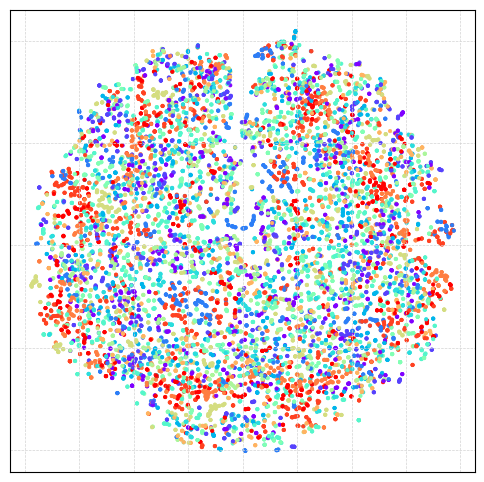

In [60]:
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from scipy.stats import sem
import tikzplotlib

mpl.rcParams['text.usetex'] = True
mpl.rc('font', family='Times New Roman', size=11)
cols = "tab10"

plt.rcParams["figure.figsize"] = (6, 6)

scatter_plot(T_SNE_sub_encoded, np.array(sub_encoded_labels)[:, 0], visible_legend=False)
plt.gca().set_title("")
# plt.gca().axis('off')
plt.grid(True, color='lightgray', linestyle='--', linewidth=0.5)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['top'].set_color('black')
plt.gca().spines['right'].set_color('black')
# plt.gca().legend().set_visible(False)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)

plt.savefig('scatter-tsne-structured.png')
plt.show()

scatter_plot(T_SNE_raw, label[subset, 0], visible_legend=False)

plt.gca().set_title("")
# plt.gca().axis('off')
plt.grid(True, color='lightgray', linestyle='--', linewidth=0.5)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['top'].set_color('black')
plt.gca().spines['right'].set_color('black')
# plt.gca().legend().set_visible(False)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)

plt.savefig('scatter-tsne-raw.png')
plt.show()


# Use other types of classification

In [30]:
import xgboost as xgb 

In [31]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42) #"multi:softprob" #'binary:logistic' multi:softmax

xgb_model.fit(encoded_train, labels_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

confusion matrix
[[ 341    0    0    8    8   82   37  154  415]
 [  43   12    0    0  123    0    0   43  854]
 [   0 1084    0    2    2    0    0    0    4]
 [   0    0    1  747    0    0    0    0  270]
 [   0    0  399    0  526    0    0   60   96]
 [   0    0    0    0    0   95  360    0  546]
 [   0    0    0   19    0    0  440    0  566]
 [   1    0    0  367   95    0    0    0  596]
 [   0   16    0    0   44    0   16    0  993]]


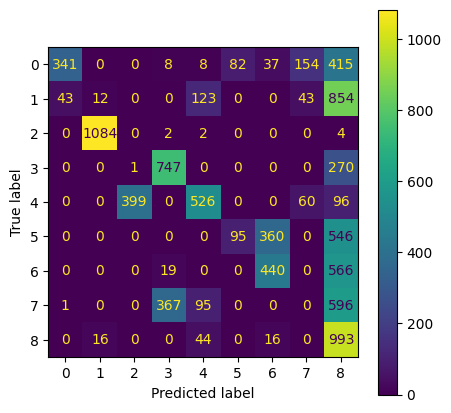

classification_report
              precision    recall  f1-score   support

           0       0.89      0.33      0.48      1045
           1       0.01      0.01      0.01      1075
           2       0.00      0.00      0.00      1092
           3       0.65      0.73      0.69      1018
           4       0.66      0.49      0.56      1081
           5       0.54      0.09      0.16      1001
           6       0.52      0.43      0.47      1025
           7       0.00      0.00      0.00      1059
           8       0.23      0.93      0.37      1069

    accuracy                           0.33      9465
   macro avg       0.39      0.33      0.30      9465
weighted avg       0.38      0.33      0.30      9465



In [32]:
predicted_class = xgb_model.predict(encoded_test)

print('confusion matrix')
conf_mx =confusion_matrix(labels_test, predicted_class)
print(conf_mx)

# Confusion Matrix Display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx,
                              display_labels=range(num_classes+1))
disp.plot()
plt.show()


print('classification_report')
print(classification_report(labels_test, predicted_class))

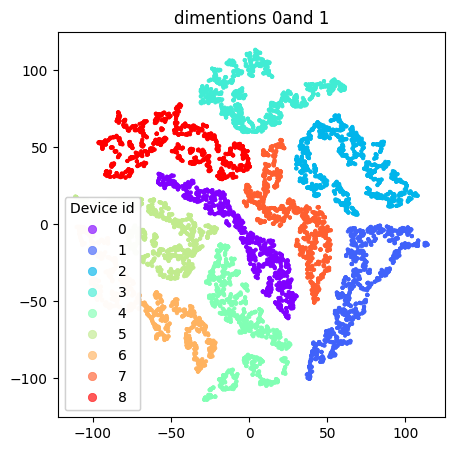

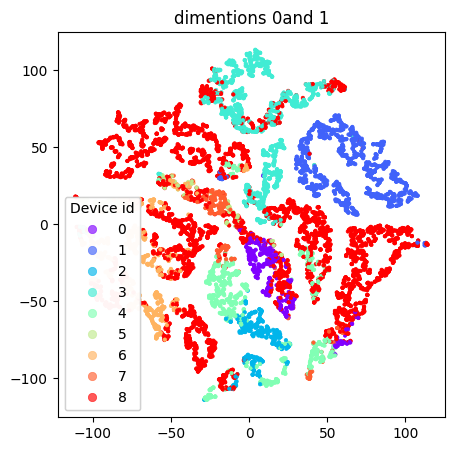

In [33]:
scatter_plot(T_SNE_test, labels_test)
scatter_plot(T_SNE_test, predicted_class)
plt.show()
